In [2]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
output

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.1386,  0.1583, -0.2967,  ..., -0.2708, -0.2844,  0.4581],
         [ 0.5364, -0.2327,  0.1754,  ...,  0.5540,  0.4981, -0.0024],
         [ 0.3002, -0.3475,  0.1208,  ..., -0.4562,  0.3288,  0.8773],
         ...,
         [ 0.3799,  0.1203,  0.8283,  ..., -0.8624, -0.5957,  0.0471],
         [-0.0252, -0.7177, -0.6950,  ...,  0.0757, -0.6668, -0.3401],
         [ 0.7535,  0.2391,  0.0717,  ...,  0.2467, -0.6458, -0.3213]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.9377, -0.5043, -0.9799,  0.9030,  0.9329, -0.2438,  0.8926,  0.2288,
         -0.9531, -1.0000, -0.8862,  0.9906,  0.9855,  0.7155,  0.9455, -0.8645,
         -0.6035, -0.6666,  0.3020, -0.1587,  0.7455,  1.0000, -0.4022,  0.4261,
          0.6151,  0.9996, -0.8773,  0.9594,  0.9585,  0.6950, -0.6718,  0.3325,
         -0.9954, -0.2268, -0.9658, -0.9951,  0.6127, -0.7670,  0.0873,  0.0824,
         -0.9518,  0.4713,  1.00

In [31]:
encoded_input

{'input_ids': tensor([[ 101, 5672, 2033, 2011, 2151, 3793, 2017, 1005, 1040, 2066, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [3]:
from transformers.utils.fx import symbolic_trace

In [4]:
traced = symbolic_trace(

    model,

    input_names=["input_ids", "attention_mask", "token_type_ids"],

)


In [9]:
import sys
sys.path.append('../src/')
import importlib
import module2graph
importlib.reload(module2graph)

<module 'module2graph' from '/home/bakhteev/reps/fast_nas_adapt/notebooks/../src/module2graph.py'>

In [64]:
g = module2graph.GraphInterperterWithGamma(traced)

In [65]:
output = g(encoded_input['input_ids'], encoded_input['attention_mask'], 
                               encoded_input['token_type_ids'])
output

tensor([[-0.9377, -0.5043, -0.9799,  0.9030,  0.9329, -0.2438,  0.8926,  0.2288,
         -0.9531, -1.0000, -0.8862,  0.9906,  0.9855,  0.7155,  0.9455, -0.8645,
         -0.6035, -0.6666,  0.3020, -0.1587,  0.7455,  1.0000, -0.4022,  0.4261,
          0.6151,  0.9996, -0.8773,  0.9594,  0.9585,  0.6950, -0.6718,  0.3325,
         -0.9954, -0.2268, -0.9658, -0.9951,  0.6127, -0.7670,  0.0873,  0.0824,
         -0.9518,  0.4713,  1.0000,  0.3299,  0.7583, -0.2670, -1.0000,  0.3166,
         -0.9364,  0.9910,  0.9719,  0.9893,  0.2190,  0.6048,  0.5849, -0.4123,
         -0.0063,  0.1719, -0.3988, -0.6190, -0.6603,  0.5069, -0.9757, -0.9039,
          0.9926,  0.9323, -0.3687, -0.4869, -0.3143,  0.0499,  0.9129,  0.3396,
         -0.1879, -0.9235,  0.8675,  0.3228, -0.6406,  1.0000, -0.7989, -0.9931,
          0.9629,  0.9124,  0.4827, -0.7276,  0.5996, -1.0000,  0.7548, -0.1600,
         -0.9941,  0.3386,  0.8394, -0.4158,  0.2943,  0.6111, -0.5745, -0.7185,
         -0.4768, -0.9681, -

In [70]:
import tqdm
original_vec = output.detach().numpy()
n_exp = 10
X = []
Y = []
rs = np.random.RandomState(42)
for i in tqdm.tqdm_notebook(range(len(g.gammas))):
    X.append(i)
    Y.append([])
    for _ in range(n_exp):
        gamma_ids = rs.choice(range(len(g.gammas)), i, replace = False)
        g.gammas[gamma_ids] = 0
        result =  g(encoded_input['input_ids'], encoded_input['attention_mask'], 
                               encoded_input['token_type_ids']).detach().numpy()
        Y[-1].append(np.linalg.norm(result - original_vec))
        g.gammas[gamma_ids] = 1

/tmp/ipykernel_197297/1832048933.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(len(g.gammas))):


  0%|          | 0/139 [00:00<?, ?it/s]

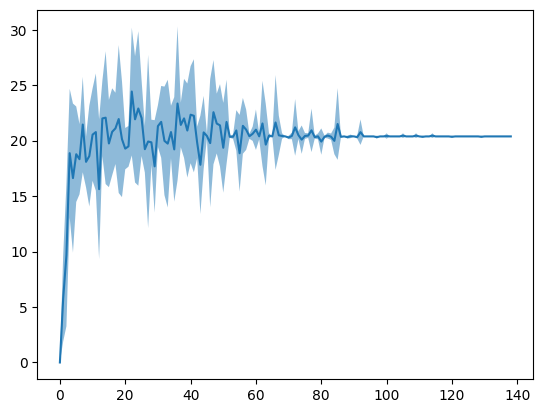

In [71]:
import matplotlib.pylab as plt
%matplotlib inline
plt.plot(X, np.mean(Y,1))
plt.fill_between(X, np.mean(Y,1) - np.std(Y,1), np.mean(Y,1) + np.std(Y,1), alpha=0.5)